# Project 1


# Setup

### Import Utils

In [1]:
import math
import scipy
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

### Import Data

Below are the `covid_confirmed_usafacts`, `npr-2016-election-data`, and `covid_county_population_usafacts` datasets used for our analysis. 

In [2]:
covid_confirmed_facts    = pd.read_csv('covid_confirmed_usafacts.csv')
election_data            = pd.read_csv('npr-2016-election-data.csv')
covid_county_population  = pd.read_csv('covid_county_population_usafacts.csv')

In In[3], In[4], In[5], we used .head() to ensure the data was properly imported in. 

In [3]:
covid_confirmed_facts.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,7306,7306,7320,7329,7341,7346,7347,7350,7365,7375
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,22337,22337,22464,22556,22642,22734,22802,22876,23032,23184
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,2367,2367,2373,2377,2386,2389,2394,2396,2411,2415
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,2704,2704,2708,2713,2719,2721,2727,2733,2747,2753


In [4]:
covid_county_population.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


In [5]:
election_data.head()

,State,Clinton,Trump
0,AK,38,53
1,AL,35,63
2,AR,34,60
3,AZ,45,50
4,CA,62,33


# Data Preperation (WE SHOULD DO SOME OTHER CHECKS)

### Aggregate by State

This note is for the following lines of code: In[6], In[7], In[8]-
We dropped the 'County Name', 'countyFIPS','StateFIPS' columns from covid_confirmed_facts since they will not be used in our analysis. Once these columns were dropped, we can aggregate the covid case data that was by county to by state. In[7] aggregates covid cases by state.

In [6]:
covid_confirmed_facts = covid_confirmed_facts.drop(columns=['County Name', 'countyFIPS', 'StateFIPS'])

covid_state_cases = covid_confirmed_facts.groupby('State').sum()

covid_state_cases.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
State,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,68977,68977,69189,69189,69453,69453,69453,69891,69891,70328
AL,0,0,0,0,0,0,0,0,0,0,...,555215,555215,556613,557578,558577,559478,560202,560920,562311,563943
AR,0,0,0,0,0,0,0,0,0,0,...,355460,358951,360259,361238,361238,361238,361238,365132,367007,367007
AZ,0,0,0,0,1,1,1,1,1,1,...,901562,901907,903852,904866,906117,906117,906117,909283,910437,911480
CA,0,0,0,0,2,3,3,4,4,4,...,3736534,3736534,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006


This note is for the following lines of code: In[9], In[10], In[11]-
We dropped 'CountyFIPS' and 'County Name' columns from covid_county_population since they will not be used in our analysis. Once these columns were dropped, we can aggregate the population that was by county to by state. We are aggregating population by state so we can merge all 3 DataFrames.

In [7]:
covid_county_population = covid_county_population.drop(columns=['countyFIPS', 'County Name'])

covid_state_population = covid_county_population.groupby('State').sum()

covid_state_population.head()

,population
State,
AK,731545
AL,4903185
AR,3017804
AZ,7278717
CA,39512223


### Merge Data Sets

Now that all unecessary columns were removed from our DataFrames, and all data is aggregated by state, we are able to merge the 3 DataFrame into 1 united DataFrame- pop_case_elec

In [8]:
pop_case_elec = covid_state_population.merge(
    covid_state_cases,
    on='State'
).merge(
    election_data,
    on='State'
)

pop_case_elec.head()

,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,Clinton,Trump
0,AK,731545,0,0,0,0,0,0,0,0,...,69189,69189,69453,69453,69453,69891,69891,70328,38,53
1,AL,4903185,0,0,0,0,0,0,0,0,...,556613,557578,558577,559478,560202,560920,562311,563943,35,63
2,AR,3017804,0,0,0,0,0,0,0,0,...,360259,361238,361238,361238,361238,365132,367007,367007,34,60
3,AZ,7278717,0,0,0,0,1,1,1,1,...,903852,904866,906117,906117,906117,909283,910437,911480,45,50
4,CA,39512223,0,0,0,0,2,3,3,4,...,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006,62,33


### Create Indicator clinton_win

The intention of In[14] and In[15] is to simplify into a binary of which states were won by CLinton or Trump. In[14] will add a column to the DataFrame named 'clinton_win' to display 'False' if Clinton lossed, and 'True' if Clinton won. The purpose of this binary column is to simplify which states voted majority for Trump or Clinton, which will be utilized in establishing correlations between different variables later. We then do some renaming to python standard snake case.

In [9]:
pop_case_elec['clinton_win'] = pop_case_elec['Clinton'] > pop_case_elec['Trump']

pop_case_elec = pop_case_elec.rename( columns={ 'State':'state', 'Clinton':'clinton', 'Trump':'trump' } )

pop_case_elec.head()

,state,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,clinton,trump,clinton_win
0,AK,731545,0,0,0,0,0,0,0,0,...,69189,69453,69453,69453,69891,69891,70328,38,53,False
1,AL,4903185,0,0,0,0,0,0,0,0,...,557578,558577,559478,560202,560920,562311,563943,35,63,False
2,AR,3017804,0,0,0,0,0,0,0,0,...,361238,361238,361238,361238,365132,367007,367007,34,60,False
3,AZ,7278717,0,0,0,0,1,1,1,1,...,904866,906117,906117,906117,909283,910437,911480,45,50,False
4,CA,39512223,0,0,0,0,2,3,3,4,...,3743242,3747897,3747897,3747897,3761997,3766720,3772006,62,33,True


### Summary Set

The below code was done to show a summary of the pop_case_elec DataFrame. This DataFrame will be named sum_pop_case_elec. 

To make sum_pop_case_elec, we dropped all case columns except for the '2021-07-21' column, which displays the cumulative cases on  up to 7/21/2021. This was saved as 'total_cases'. 

Next we computed the 'month_cases' column, which gives the cases for the past month. This was done by subtracting cumlative cases on 7/21/2021 by cumulative cases on 6/21/2021. 

The 'cases_per_cap' column was added by dividing the 'total_cases' column by the 'population' column. 

These new columns will be referenced when looking into different correlations later. 

In [10]:
sum_pop_case_elec = pop_case_elec

sum_pop_case_elec['total_cases'] = pop_case_elec['2021-07-21']
sum_pop_case_elec['cases_per_cap'] = sum_pop_case_elec['total_cases'] / sum_pop_case_elec['population']

sum_pop_case_elec = sum_pop_case_elec.drop(sum_pop_case_elec.iloc[:, 2:-5], axis=1)

sum_pop_case_elec.head()

,state,population,clinton,trump,clinton_win,total_cases,cases_per_cap
0,AK,731545,38,53,False,70328,0.096136
1,AL,4903185,35,63,False,563943,0.115016
2,AR,3017804,34,60,False,367007,0.121614
3,AZ,7278717,45,50,False,911480,0.125225
4,CA,39512223,62,33,True,3772006,0.095464


### Cases Time Series

Insert Notes

In [11]:
cases_ts = pop_case_elec.iloc[:, :-6]

cases_ts = cases_ts.set_index('state')

cases_ts = cases_ts.drop(columns=['population'])

cases_ts.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-07-11,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20
state,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,68793,68977,68977,69189,69189,69453,69453,69453,69891,69891
AL,0,0,0,0,0,0,0,0,0,0,...,554605,555215,555215,556613,557578,558577,559478,560202,560920,562311
AR,0,0,0,0,0,0,0,0,0,0,...,355460,355460,358951,360259,361238,361238,361238,361238,365132,367007
AZ,0,0,0,0,1,1,1,1,1,1,...,899830,901562,901907,903852,904866,906117,906117,906117,909283,910437
CA,0,0,0,0,2,3,3,4,4,4,...,3724362,3736534,3736534,3739625,3743242,3747897,3747897,3747897,3761997,3766720


# Quantitative Exploration

The following section contains all of the correlations we were supposed to show. In our correltions, we fitted our logistics model to all correltions to see if it'd be a good indicator between the following correlations.

## Correlations

The following heatmap displays all variables and their correlations with each other. 

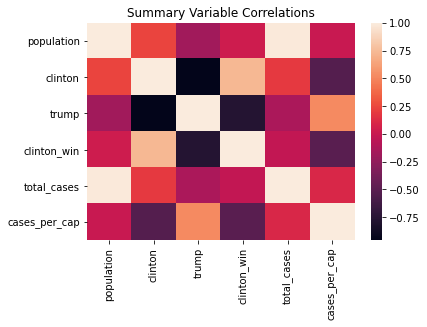

In [12]:
_ = sns.heatmap( sum_pop_case_elec.corr() )

_ = plt.title('Summary Variable Correlations')

plt.show()

From the heatmap created, we can see variables with a tanner color show more correlation, where as colors that are more purple show negative correlation. This heatmap will be a good indicator to understand which variable correlations may warrant a hyptheses test. 

## Modeling

The following seciton contains our regression funciton, logistic_model funciton, linear_model function and make_projection function. 

### Modeling Utilities

The following regression function is made to interact with the curve_fit package in scipy.optimize import. The following function will find the covariance and betas for a correlation when applying the logistics model.

In [13]:
from scipy.optimize import curve_fit

def regression( model, x_data, y_data ):
    found_betas = []
    covariance  = 0
    
    found_betas, covariance = curve_fit( model, x_data, y_data )
        
    return found_betas, covariance

The logistic_model function is used to fit in our correlations made. 

In [14]:
def logistic_model( x, beta_0, beta_1, beta_2 ):
    return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x ))) 

The linear_model was used prior to applying our logistics model to our correlations. This was used as a test to ensure our other functions interacted properly with the model. 

In [15]:
def linear_model( x, beta_0, beta_1 ):
    return ( beta_0 * x ) + beta_1

The make_projections model interacts with either our linear_model or logistic_model functions and the pop_case_elec DataFrame. 

In [16]:
def make_projection( model, x_data, y_data, points ):     
    betas, covariance = regression( model, x_data, y_data )
    
    x_proj = np.linspace( 0, points, num=points )
    y_proj = model( x_proj, *betas )
    
    return x_proj, y_proj

In [17]:
def project_max( y_data ):
    x_len = y_data.shape[0]
    
    x_data = np.linspace( 0, x_len, num=x_len )
    
    x_proj, y_proj = make_projection( logistic_model, x_data, y_data, 2000 )
    
    return np.round(np.max(y_proj))

In [18]:
def get_max_inc( y_data ):
    x_len = y_data.shape[0]
    
    x_data = np.linspace( 0, x_len, num=x_len )
    
    found_betas, covariance = regression( logistic_model, x_data, y_data )
    
    return found_betas[2]

Using the make_projections function, we are able to use our logistic_model to fit to our correlations. Assuming the correlaitons are similiar to the logistic_model output, we can further explore the correlation using a hypothesis test. 

## Case Projections

Below contains all code that utlizes the pop_case_election DataFrame to show correlation between different variables. 

### Projected Max Cases Visualization

We want to use our logistic_model to see if it would be a good predictor for cases in MA vs days passed. 

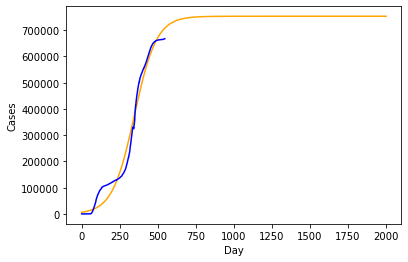

PROJECTED MAX CASES:
753058.0


In [19]:
ma_cases  = cases_ts.loc['MA']

num_days = ma_cases.shape[0]
days = np.linspace( 0, num_days, num=num_days )


days_proj = 2000
days_proj, case_proj = make_projection( logistic_model, days, ma_cases, days_proj )

_ = plt.plot( days_proj, case_proj, color='orange' )
_ = plt.plot( days, ma_cases, color='blue' ) 

_ = plt.xlabel('Day')
_ = plt.ylabel('Cases')

plt.show()

print('PROJECTED MAX CASES:')
print(np.round(np.max(case_proj)))

Based off this result, we can see our logistic model (in orange) can be a good model to be used to predict cases in MA. 

### Add Projected Max Cases

In [20]:
projected = cases_ts.aggregate( func=project_max, axis=1 )

pop_case_elec = pop_case_elec.merge( projected.to_frame(name='projected_max'), on='state')

<ipython-input-14-6f2958086ae9>:2: RuntimeWarning: overflow encountered in exp
  return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x )))


### Add Projected Max Per Capita

In [21]:
pop_case_elec['projected_max_per_cap'] = pop_case_elec['projected_max'] / pop_case_elec['population'] 

### Add Average Rate of Increase

In [22]:
total_days = pop_case_elec.shape[1]

pop_case_elec['avg_rate_increase'] = ( pop_case_elec['2021-07-21'] - pop_case_elec['2020-01-22'] ) / total_days

### Add Time of Max Increase

In [23]:
projected = cases_ts.aggregate( func=get_max_inc, axis=1 )

pop_case_elec = pop_case_elec.merge( projected.to_frame(name='time_max_inc'), on='state')

pop_case_elec.head()

<ipython-input-14-6f2958086ae9>:2: RuntimeWarning: overflow encountered in exp
  return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x )))


,state,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-21,clinton,trump,clinton_win,total_cases,cases_per_cap,projected_max,projected_max_per_cap,avg_rate_increase,time_max_inc
0,AK,731545,0,0,0,0,0,0,0,0,...,70328,38,53,False,70328,0.096136,66940.0,0.091505,126.489209,324.016075
1,AL,4903185,0,0,0,0,0,0,0,0,...,563943,35,63,False,563943,0.115016,573680.0,0.117002,1014.285971,313.147238
2,AR,3017804,0,0,0,0,0,0,0,0,...,367007,34,60,False,367007,0.121614,358860.0,0.118914,660.084532,315.115621
3,AZ,7278717,0,0,0,0,1,1,1,1,...,911480,45,50,False,911480,0.125225,949218.0,0.130410,1639.352518,325.282570
4,CA,39512223,0,0,0,0,2,3,3,4,...,3772006,62,33,True,3772006,0.095464,3876045.0,0.098097,6784.183453,325.664322


## Recent Cases

### Recent Cases Model Linear

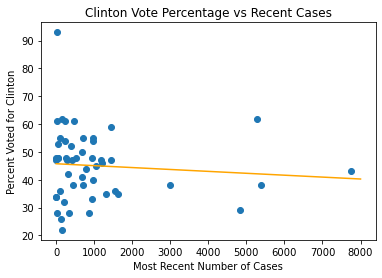

In [24]:
recent_cases       = pop_case_elec['2021-07-21'] - pop_case_elec['2021-07-20']
clinton_percentage = pop_case_elec['clinton']

_ = plt.scatter( recent_cases, clinton_percentage )

_ = plt.xlabel('Most Recent Number of Cases')
_ = plt.ylabel('Percent Voted for Clinton')

_ = plt.title('Clinton Vote Percentage vs Recent Cases')


betas, covariance = regression( linear_model, recent_cases, clinton_percentage )

x = np.linspace(0, 8000, num=100)
y = linear_model( x, betas[0], betas[1] )

plt.plot( x, y, color='orange' )

plt.show()

## Recent Cases Per Capita

### Recent Cases Per Capita Linear Model

[]

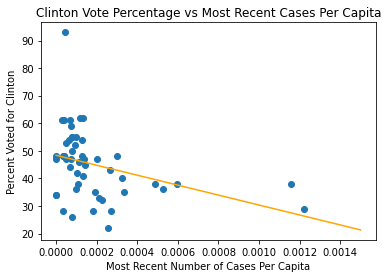

In [25]:
recent_cases_per_cap = recent_cases / pop_case_elec['population']

_ = plt.scatter( recent_cases_per_cap, clinton_percentage )

_ = plt.xlabel('Most Recent Number of Cases Per Capita')
_ = plt.ylabel('Percent Voted for Clinton')

_ = plt.title('Clinton Vote Percentage vs Most Recent Cases Per Capita')

betas, covariance = regression( linear_model, recent_cases_per_cap, clinton_percentage )

x = np.linspace(0, 0.0015, num=100 )
y = linear_model( x, betas[0], betas[1] )

_ = plt.plot( x, y, color='orange' )

plt.plot()

In [26]:
print(covariance)

[[ 4.59997755e+07 -8.38631787e+03]
 [-8.38631787e+03  4.22199391e+00]]


In [27]:
numpy_cov = np.cov( recent_cases_per_cap, clinton_percentage )

In [28]:
corr = numpy_cov[0,1]
print(corr)

-0.0010772832216615212


In [29]:
def state_covid_cases(state):
    chosen_state = pop_case_elec[pop_case_elec['state'] == state]
    return chosen_state

# state= str(input("Enter State Abbreviation:"))

state_covid_cases(state)


NameError: name 'state' is not defined